<a href="https://colab.research.google.com/github/tanvir-152/Thesis_Codes/blob/main/1DCNN_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/thesis_code

/content/drive/MyDrive/thesis_code


In [ ]:
!pip install tensorflow==1.14

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 48 kB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 3.1 MB 59.4 MB/s 
     |████████████████████████████████| 488 kB 59.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0+zzzcolab20220506162203
    Uninstalling tensorflow-2.8.0+zzzcolab20220506162203:
      Successfully uninstalled tensorflow-2.8.0+zzzcolab20220506162203
ERROR: pip's dependency resolver does not currently ta

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as scio
import scipy.io as sio

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
from tf_utils import random_mini_batches_single, convert_to_one_hot
from tensorflow.python.framework import ops

In [ ]:
pip install tensorflow-determinism

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for tensorflow-determinism: filename=tensorflow_determinism-0.3.0-py3-none-any.whl size=9158 sha256=6315409e0622073f50513f801e9b904bda6d2c1f9a105d02c6130d14ae1bf1d7
  Stored in directory: /root/.cache/pip/wheels/d2/be/33/2b27e81e5d40b4bfb7c103ac6c6c5e81fdbcf40d2af5078529
Successfully built tensorflow-determinism


In [ ]:
from tfdeterminism import patch
patch()

TensorFlow version 1.14.0 has been patched using tfdeterminism version 0.3.0


In [ ]:
def create_placeholders(n_x, n_y):

    isTraining = tf.placeholder_with_default(True, shape=())
    x = tf.placeholder(tf.float32, [None, n_x], name = "x")
    y = tf.placeholder(tf.float32, [None, n_y], name = "Y")

    return x, y, isTraining

In [ ]:
def initialize_parameters():


    tf.set_random_seed(1)

    x_w1 = tf.get_variable("x_w1", [1,1,200,128], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    x_b1 = tf.get_variable("x_b1", [128], initializer = tf.zeros_initializer())

    x_w2 = tf.get_variable("x_w2", [1,1,128,16], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    x_b2 = tf.get_variable("x_b2", [16], initializer = tf.zeros_initializer())

    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_w2": x_w2,
                  "x_b2": x_b2}

    return parameters

In [ ]:
def mynetwork(x, parameters, isTraining, momentums = 0.9):

    x = tf.reshape(x, [-1, 1, 1, 200], name = "x")

    with tf.name_scope("x_layer_1"):

         x_z1 = tf.nn.conv2d(x, parameters['x_w1'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_b1']
         x_z1_bn = tf.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
         x_a1 = tf.nn.relu(x_z1_bn)

    with tf.name_scope("x_layer_3"):

         x_z2 = tf.nn.conv2d(x_a1, parameters['x_w2'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_b2']

         x_z2_shape = x_z2.get_shape().as_list()
         x_z2_2d = tf.reshape(x_z2, [-1, x_z2_shape[1] * x_z2_shape[2] * x_z2_shape[3]])


    l2_loss =   tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_w2'])

    return x_z2_2d, l2_loss

In [ ]:
print(tf. __version__)

1.14.0


In [ ]:
def mynetwork_optimaization(y_es, y_re, l2_loss, reg, learning_rate, global_step):

    with tf.name_scope("cost"):

         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_es, labels = y_re)) + reg * l2_loss

    with tf.name_scope("optimization"):
         update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost, global_step=global_step)
         optimizer = tf.group([optimizer, update_ops])

    return cost, optimizer

In [ ]:
def train_mynetwork(x_train_set, y_train_set, x_test_set, y_test_set, learning_rate_base = 0.001, beta_reg = 0.001, num_epochs = 200, minibatch_size = 32, print_cost = True):

    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 1
    (m, n_x) = x_train_set.shape
    (m, n_y) = y_train_set.shape

    costs = []
    costs_dev = []
    train_acc = []
    val_acc = []
    correct_prediction = 0

    # Create Placeholders of shape (n_x, n_y)
    x, y, isTraining = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()

    with tf.name_scope("network"):

         x_out, l2_loss= mynetwork(x, parameters, isTraining)

    global_step = tf.Variable(0, trainable = False)
    learning_rate = tf.train.exponential_decay(learning_rate_base, global_step, 50 * m/minibatch_size, 0.5, staircase = True)

    with tf.name_scope("optimization"):
         # network optimization
         cost, optimizer = mynetwork_optimaization(x_out, y, l2_loss, beta_reg, learning_rate, global_step)

    with tf.name_scope("metrics"):
         # Calculate the correct predictions
         joint_layerT = tf.transpose(x_out)
         yT = tf.transpose(y)
         correct_prediction = tf.equal(tf.argmax(joint_layerT), tf.argmax(yT))
         accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:

        # Run the initialization
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs + 1):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            epoch_acc = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches_single(x_train_set, y_train_set, minibatch_size, seed)
            for minibatch in minibatches:

                # Select a minibatch
                (batch_x, batch_y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _, minibatch_cost, minibatch_acc = sess.run([optimizer, cost, accuracy], feed_dict={x: batch_x, y: batch_y, isTraining: True})

                epoch_cost += minibatch_cost / (num_minibatches+ 1)
                epoch_acc += minibatch_acc / (num_minibatches + 1)

            features, epoch_cost_dev, epoch_acc_dev = sess.run([x_out, cost, accuracy], feed_dict={x: x_test_set, y: y_test_set, isTraining: False})

            # Print the cost every epoch
            if print_cost == True and (epoch) % 50 == 0:
                print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost, epoch_cost_dev, epoch_acc, epoch_acc_dev))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                train_acc.append(epoch_acc)
                costs_dev.append(epoch_cost_dev)
                val_acc.append(epoch_acc_dev)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.plot(np.squeeze(costs_dev))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        # plot the accuracy
        plt.plot(np.squeeze(train_acc))
        plt.plot(np.squeeze(val_acc))
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        return parameters, val_acc, features


In [ ]:
Train_X = scio.loadmat('HSI_GCN/Train_X.mat')
TrLabel = scio.loadmat('HSI_GCN/TrLabel.mat')

In [ ]:
Test_X = scio.loadmat('HSI_GCN/Test_X.mat')
TeLabel = scio.loadmat('HSI_GCN/TeLabel.mat')

In [ ]:
Train_X = Train_X['Train_X']
TrLabel = TrLabel['TrLabel']
Test_X = Test_X['Test_X']
TeLabel = TeLabel['TeLabel']

In [ ]:
TrLabel = convert_to_one_hot(TrLabel-1, 16)
TeLabel = convert_to_one_hot(TeLabel-1, 16)

In [ ]:
TrLabel = TrLabel.T
TeLabel = TeLabel.T

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

epoch 0: Train_loss: 2.118459, Val_loss: 2.214668, Train_acc: 0.255682, Val_acc: 0.357460
epoch 50: Train_loss: 0.482922, Val_loss: 2.442783, Train_acc: 0.829545, Val_acc: 0.405439
epoch 100: Train_loss: 0.315447, Val_lo

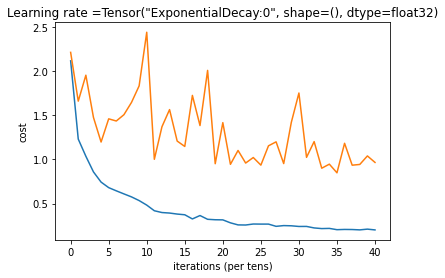

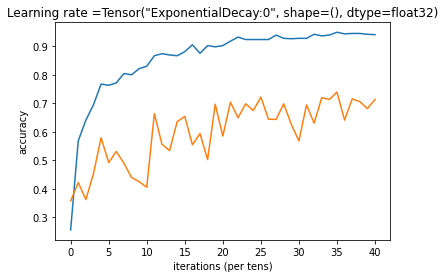

Parameters have been trained!


In [ ]:
parameters, val_acc, features = train_mynetwork(Train_X, TrLabel, Test_X, TeLabel)
sio.savemat('features.mat', {'features': features})